In [2]:
import random
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, roc_auc_score
import torch
import torchaudio
import os
from torch.utils.data import DataLoader
from LungDataSet import LungDataSet
from train_LSTM import Net_1, GRUNet
import plotly.express as px

MODEL_PATH = './CheckpointModels'
dataset_folder = '../HF_Lung_V1'
test_data_path = os.path.join(dataset_folder, 'test')
SAMPLE_RATE = 4000
ALL_LABELS = ['I', 'D', 'E', 'Rhonchi', 'Wheeze', 'Stridor']

In [3]:
def label_encoder(labels, windows, sample_rate):
    labels_dict = {label: i for i, label in enumerate(ALL_LABELS)}
    labels_array = torch.zeros(windows, len(ALL_LABELS))
    start = 0
    end = 15*sample_rate
    window_size = (end - start) / windows
    row_starts = labels['start'].to_numpy() * sample_rate
    row_ends = labels['end'].to_numpy() * sample_rate
    for i in range(windows):
        win_start = i*window_size + start
        win_end = win_start + window_size
        relevant_rows = (row_starts <= win_start) & (row_ends >= win_end)
        relevant_labels = labels['class'].to_numpy()[relevant_rows]
        label_indices = [labels_dict[label] for label in relevant_labels]
        labels_array[i, label_indices] = 1
    return labels_array

In [4]:
def set_random_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    print(f'Random seed {seed} has been set.')

In [5]:
def collate_fn(batch):
    tensors, targets = [], []
    for waveform, label in batch:
        tensors += [waveform.squeeze().t()]
        targets += [label]
    tensors = torch.stack(tensors)  
    targets = torch.stack(targets)
    return tensors, targets


def create_dataloader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                  drop_last=True, num_workers=0, pin_memory=True, collate_fn=collate_fn)
    return train_dataloader

In [6]:
def plot_roc_curves(y_true, y_pred_prob, model_name):
    df_roc = pd.DataFrame(columns=["fpr", "tpr", "label", "auc_score"])
    fig = plt.figure()
    # loop through each label
    for i in range(len(ALL_LABELS)):
        # calculate the false positive rate, true positive rate, and AUC score
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        auc_score = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
        df_roc.loc[i] = [fpr, tpr, ALL_LABELS[i], auc_score]
        plt.plot(df_roc["fpr"][i], df_roc["tpr"][i], label=f"{ALL_LABELS[i]} (AUC = {df_roc['auc_score'][i]:.2f})")

    plt.title(f'ROC Curve {model_name}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    # plt.savefig("./Figures/roc_{}".format(model_name))
    return df_roc['auc_score'].to_list()

In [7]:
def test_model(model, test_loader, model_name, device):
    output_threshold = 0.5
    true_labels = []
    predicted_labels = []
    predicted_probs = []
    model.eval()
    with torch.no_grad():
        for idx, (data, labels) in enumerate(test_loader):
            data = data
            labels = labels
            out = model(data)
            pred = out.numpy() > output_threshold
            out_shape = labels.shape
            true_labels.append(labels.numpy().reshape(-1, out_shape[-1]))
            predicted_labels.append(pred.reshape(-1, out_shape[-1]))
            predicted_probs.append(out.numpy().reshape(-1, out_shape[-1]))

    true_labels = np.concatenate(true_labels, axis=0)
    predicted_labels = np.concatenate(predicted_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    testing_accuracy = (true_labels == predicted_labels).mean(axis=0)
    
    cm = multilabel_confusion_matrix(true_labels, predicted_labels)

    TP = sum(cm[:, 1, 1])
    FP = sum(cm[:, 0, 1])
    FN = sum(cm[:, 1, 0])

    array_metrics = []
    # calculate micro-averaged precision, recall, and F1 score
    micro_precision = TP / (TP + FP)
    micro_recall = TP / (TP + FN)
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)

    auc_scores = plot_roc_curves(true_labels, predicted_probs, model_name)

    array_metrics.extend([model_name, micro_precision,micro_recall, micro_f1, sum(auc_scores)/len(auc_scores), sum(testing_accuracy)/len(testing_accuracy)])
        
    return array_metrics, testing_accuracy


In [8]:
def test_multiple_models(models, test_loaders, model_names, device):
    df_metrics = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1', 'AUC', 'Accuracy'])
    acc_scores = []
    for i in range(len(models)):
        df_metrics.loc[i], accuracy = test_model(models[i], test_loaders[i], model_names[i], device)
        acc_scores.append(accuracy)
    acc_scores = np.stack(acc_scores)
    return df_metrics, acc_scores

def plot_accuracy_boxplot(model_names, accuracy_scores, filename):
    data = []
    for i, model_name in enumerate(model_names):
        for j, label in enumerate(ALL_LABELS):
            data.append({"Model": model_name, "Label": label, "Accuracy": accuracy_scores[i][j]*100})
    df = pd.DataFrame(data)

    plt.figure(figsize=(10,7))
    ax = sns.boxplot(df, x="Model", y="Accuracy", palette="Blues", width=0.5)
    ax.set_title("Accuracy Scores for Multiple Models")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy")
    ax.yaxis.grid(True)
    plt.tight_layout()
    sns.set_style("ticks")
    # plt.savefig(filename)
    plt.show()

In [9]:
def plot_metrics_radar(df_metrics):
    metrics = ['Precision', 'Recall', 'F1', 'AUC', 'Accuracy']
    stats = df_metrics[metrics].values
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))
    metrics.append(metrics[0])

    fig=plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, polar=True)

    for i in range(len(stats)):
        stat = stats[i]
        stat=np.concatenate((stat,[stat[0]]))
        ax.plot(angles, stat, 'o-', linewidth=2, label=df_metrics['Model'].loc[i])
        # ax.fill(angles, stat, alpha=0.25)

    ax.set_thetagrids(angles * 180/np.pi, metrics)

    ax.grid(True)
    fig.legend()

In [10]:
colors = px.colors.qualitative.T10
template = "plotly_white"
layout = dict(template=template, xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))
seed = 0
set_random_seeds(seed)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

list_files = []
data_folder = test_data_path
for file in os.listdir(data_folder):
    if file.endswith(".wav"):
        list_files.append(os.path.join(
            data_folder, os.path.splitext(file)[0]))

Random seed 0 has been set.
Using device cpu


In [11]:
models=[]
model_names=[]
data_loaders=[]

### lstm mel 

In [12]:
signal_transforms = []
num_features = 0
window_function = torch.hamming_window
window_length = 256
hop_length = 64
n_bands = 256

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_bands,
    win_length=window_length,
    hop_length=hop_length,
    window_fn=window_function,
    n_mels=n_bands//2 +1,
)

signal_transforms.append(mel_spectrogram)
num_features += (n_bands//2 + 1)

test_dataset_129_mels = LungDataSet(list_files, 
                           transformations=signal_transforms, 
                           targets_transform=label_encoder)

batch_size = 256
test_loader_1 = create_dataloader(test_dataset_129_mels, batch_size)
data_loaders.append(test_loader_1)

hidden_layers = 256
lstm_2x256h_mel = Net_1(input_dimensions=num_features, n_hidden=hidden_layers, output_dimensions=len(
    ALL_LABELS), n_layers=2, drop_prob=0.2, bidirectional=False, device=device)

model_file_name = os.path.join(MODEL_PATH, 'model_2x256h_50_mel.pt')
lstm_2x256h_mel.load_state_dict(torch.load(model_file_name, map_location=torch.device(device)))
model_name = 'LSTM 129 Mel'

# test_accuracy = test_model(lstm_2x256h_mel, test_loader_1, model_name, device)
# print("Accuracies: ", test_accuracy)
models.append(lstm_2x256h_mel)
model_names.append(model_name)


c:\Source\Time Series Analysis\venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (129) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


### lstm spec

In [13]:
signal_transforms = []
num_features = 0
window_function = torch.hamming_window
window_length = 256
hop_length = 64
n_bands = 256
spectrogram = torchaudio.transforms.Spectrogram(
    # sample_rate=SAMPLE_RATE,
    n_fft=n_bands,
    win_length=window_length,
    hop_length=hop_length,
    window_fn=window_function
)
n_mfccs = 60
mfcc = torchaudio.transforms.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=n_mfccs,
    log_mels=True,
    melkwargs={"n_fft": n_bands, 
            "win_length":window_length,
            "hop_length": hop_length, 
            "n_mels": n_bands//2 + 1,
            "window_fn": window_function, 
            "f_min": 0,
            "f_max": SAMPLE_RATE},
)
signal_transforms.append(spectrogram)
num_features += (n_bands//2 + 1)

signal_transforms.append(mfcc)
num_features += n_mfccs

test_dataset_189_spec = LungDataSet(list_files, 
                           transformations=signal_transforms, 
                           targets_transform=label_encoder)

batch_size = 256
test_loader_2 = create_dataloader(test_dataset_189_spec, batch_size)
data_loaders.append(test_loader_2)

hidden_layers = 256
lstm_2x256h_spec = Net_1(input_dimensions=num_features, n_hidden=hidden_layers, output_dimensions=len(
    ALL_LABELS), n_layers=2, drop_prob=0.2, bidirectional=False, device=device)
model_file_name = os.path.join(MODEL_PATH, 'model_2x256h_50_spec.pt')
lstm_2x256h_spec.load_state_dict(torch.load(model_file_name, map_location=torch.device(device)))
model_name = 'LSTM 189 Spectogram+MFCC'

models.append(lstm_2x256h_spec)
model_names.append(model_name)

c:\Source\Time Series Analysis\venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (129) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


### lstm mel large window

In [14]:
signal_transforms = []
num_features = 0
window_function = torch.hamming_window
window_length = 4000
hop_length = 2000
n_bands = 4000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_bands,
    win_length=window_length,
    hop_length=hop_length,
    window_fn=window_function,
    n_mels=n_bands//2 +1,
    f_min=0,
    f_max=SAMPLE_RATE
)

signal_transforms.append(mel_spectrogram)
num_features += (n_bands//2 + 1)

test_dataset_30_mel = LungDataSet(list_files, 
                           transformations=signal_transforms, 
                           targets_transform=label_encoder)

batch_size = 256
test_loader_3 = create_dataloader(test_dataset_30_mel, batch_size)
data_loaders.append(test_loader_3)

hidden_layers = 256
lstm_256_30_mels = Net_1(input_dimensions=num_features, n_hidden=hidden_layers, output_dimensions=len(
    ALL_LABELS), n_layers=2, drop_prob=0.2, bidirectional=False, device=device)
model_file_name = os.path.join(MODEL_PATH, 'model_lstm_256_30_mels_45.pt')
lstm_256_30_mels.load_state_dict(torch.load(model_file_name, map_location=torch.device(device)))
model_name = 'LSTM Large Frames'

models.append(lstm_256_30_mels)
model_names.append(model_name)

c:\Source\Time Series Analysis\venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (2001) may be set too high. Or, the value for `n_freqs` (2001) may be set too low.
  warnings.warn(


### bilstm mel

In [15]:
signal_transforms = []
num_features = 0
window_function = torch.hamming_window
window_length = 256
hop_length = 64
n_bands = 256

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_bands,
    win_length=window_length,
    hop_length=hop_length,
    window_fn=window_function,
    n_mels=n_bands//2 +1,
)

signal_transforms.append(mel_spectrogram)
num_features += (n_bands//2 + 1)

test_dataset_129_mels = LungDataSet(list_files, 
                           transformations=signal_transforms, 
                           targets_transform=label_encoder)

batch_size = 256
test_loader_1 = create_dataloader(test_dataset_129_mels, batch_size)
data_loaders.append(test_loader_1)

hidden_layers = 128
bi_lstm = Net_1(input_dimensions=num_features, n_hidden=hidden_layers, output_dimensions=len(
    ALL_LABELS), n_layers=1, drop_prob=0, bidirectional=True, device=device)

model_file_name = os.path.join(MODEL_PATH, 'model_1x128_bi_49.pt')
bi_lstm.load_state_dict(torch.load(model_file_name, map_location=torch.device(device)))
model_name = 'biLSTM 129 mel'

# test_accuracy = test_model(lstm_2x256h_mel, test_loader_1, model_name, device)
# print("Accuracies: ", test_accuracy)
models.append(bi_lstm)
model_names.append(model_name)


c:\Source\Time Series Analysis\venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (129) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


### gru mel 

In [16]:
signal_transforms = []
num_features = 0
window_function = torch.hamming_window
window_length = 256
hop_length = 64
n_bands = 256

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_bands,
    win_length=window_length,
    hop_length=hop_length,
    window_fn=window_function,
    n_mels=n_bands//2 +1,
)

signal_transforms.append(mel_spectrogram)
num_features += (n_bands//2 + 1)

test_dataset_129_mels = LungDataSet(list_files, 
                           transformations=signal_transforms, 
                           targets_transform=label_encoder)

batch_size = 256
test_loader_4 = create_dataloader(test_dataset_129_mels, batch_size)
data_loaders.append(test_loader_1)

hidden_layers = 256
gru_2x256_mel = GRUNet(input_dimensions=num_features, n_hidden=hidden_layers, output_dimensions=len(
    ALL_LABELS), n_layers=2, drop_prob=0.2, bidirectional=False, device=device)

model_file_name = os.path.join(MODEL_PATH, 'model_gru_2x256h_mel_47.pt')
gru_2x256_mel.load_state_dict(torch.load(model_file_name, map_location=torch.device(device)))
model_name = 'GRU 129 Mel'

# test_accuracy = test_model(lstm_2x256h_mel, test_loader_1, model_name, device)
# print("Accuracies: ", test_accuracy)
models.append(gru_2x256_mel)
model_names.append(model_name)


c:\Source\Time Series Analysis\venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (129) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


bigru mel

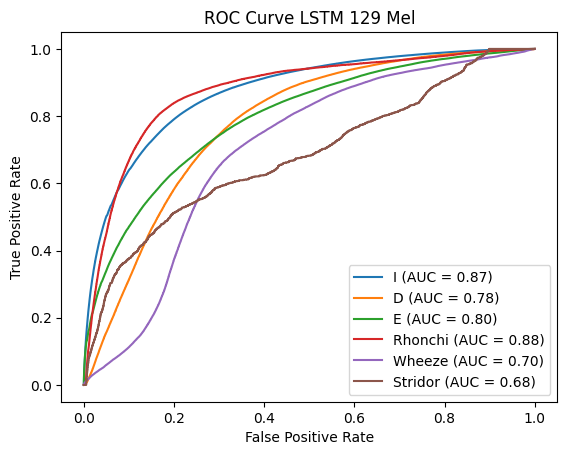

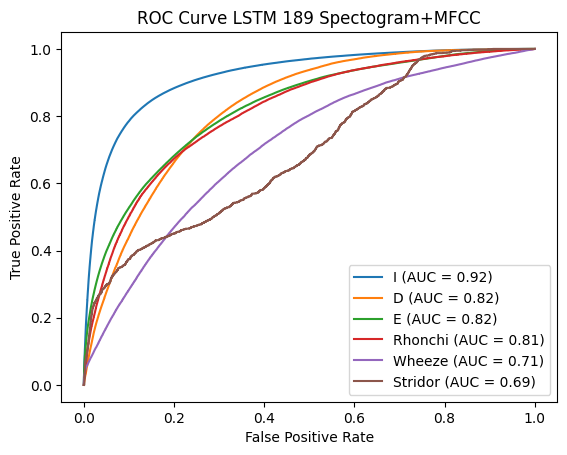

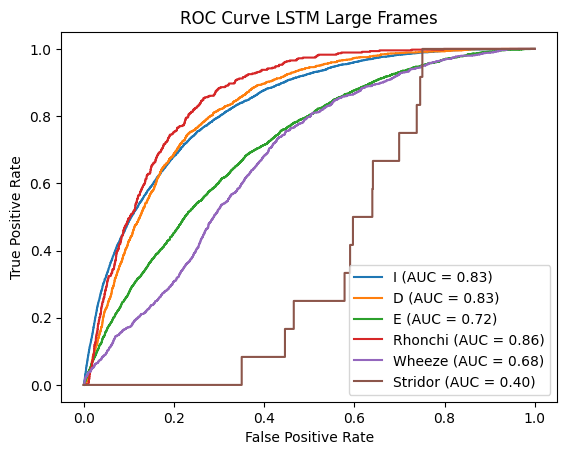

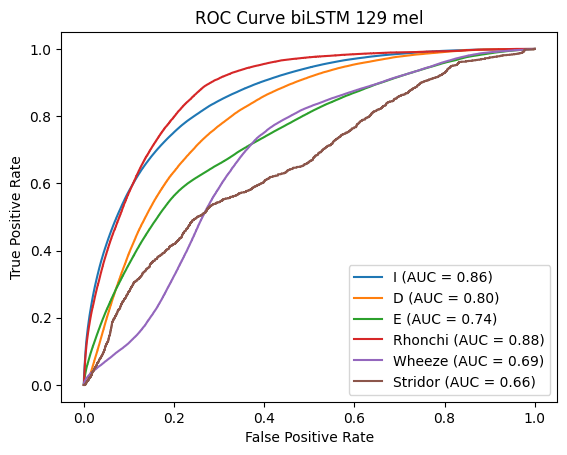

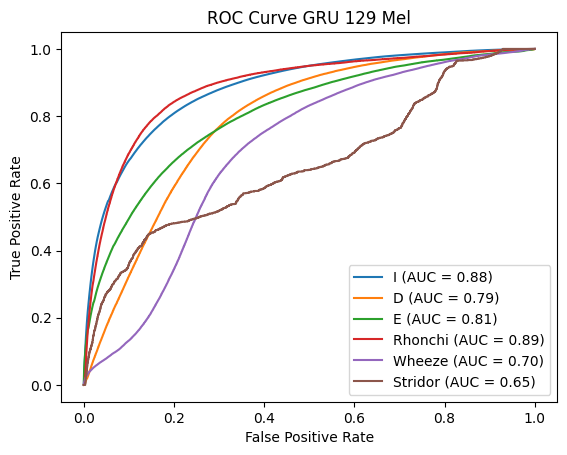

In [17]:
df_metrics, accuracy_scores = test_multiple_models(models, data_loaders, model_names, device)
# plot_accuracy_boxplot(model_names, accuracy_scores, './Figures/accuracy_boxplot_{}.html'.format('_'.join(model_names)))

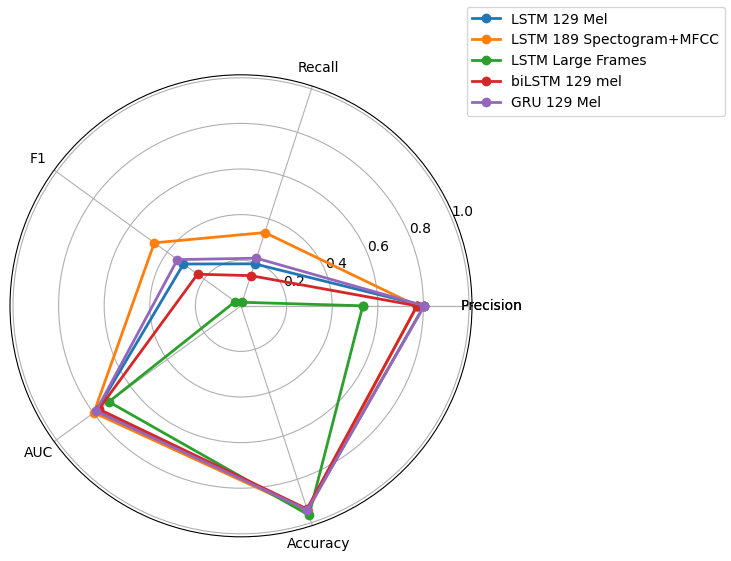

In [18]:
plot_metrics_radar(df_metrics)

In [19]:
df_metrics

,Model,Precision,Recall,F1,AUC,Accuracy
0,LSTM 129 Mel,0.802626,0.193610,0.311967,0.783947,0.940679
1,LSTM 189 Spectogram+MFCC,0.771383,0.337899,0.469943,0.797656,0.946197
2,LSTM Large Frames,0.534286,0.016326,0.031684,0.716350,0.965708
3,biLSTM 129 mel,0.772456,0.139146,0.235813,0.770865,0.936750
4,GRU 129 Mel,0.804039,0.219516,0.344876,0.785865,0.941867
